# Topics & trends in NSF-OCE awards
Created by Ivan Lima on Tue Feb 13 2018 10:13:25 -0500

Last modified on Thu Aug 16 2018 17:11:54 -0400

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker, colors
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50

## Read award data, topic probabilities & t-SNE embedding vectors

In [2]:
store = pd.HDFStore('results/tf_lda_awards_topics.h5')
awards = store['awards']
store.close()

npzf = np.load('results/tf_lda_tsne.npz')
feature_names = npzf['feature_names']
lda_components = npzf['lda_components']
X_topics = npzf['X_topics']              # topic probabilities (11238 awards x 20 topics)
n_abstracts, n_topics = X_topics.shape
X_tsne = npzf['X_tsne']                  # t-SNE embedding vectors (11238 awards x 2 vectors)

probs = pd.DataFrame(X_topics, columns=list(range(n_topics))) # dataframe with topic probabilities for each award

### Top 10 most common words in each topic

In [3]:
sort_by_feature = np.argsort(lda_components,axis=1)[:,::-1] # descending order
cols = ['topic {:d}'.format(i+1) for i in range(lda_components.shape[0])]
df_topics = pd.DataFrame(feature_names[sort_by_feature][:,:10].transpose(), columns=cols)
topic_names = np.array(['{} {:2d}'.format(' '.join(words),n+1) for n, words in 
                        enumerate(feature_names[sort_by_feature[:,:3]])])
topic_names_r = np.array(['{} {}'.format(s.split()[-1], ' '.join(s.split()[:3])) for s in topic_names])
df_topics

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,topic 12,topic 13,topic 14,topic 15,topic 16,topic 17,topic 18,topic 19,topic 20
0,sensor,coral,workshop,record,hydrothermal,temperature,organic,wave,population,vessel,production,microbial,ecosystem,gulf,specie,ridge,circulation,coastal,seismic,trace
1,instrument,reef,education,core,vent,depth,matter,flow,fish,equipment,nitrogen,phytoplankton,coastal,gas,population,mantle,atlantic,shelf,margin,element
2,technology,host,international,past,fluid,series,compound,eddy,larval,operate,nutrient,cell,human,oil,predator,spread,variability,transport,earthquake,isotope
3,capability,ecosystem,school,isotope,ridge,mooring,dissolve,numerical,zooplankton,ship,oxygen,bacteria,environmental,co2,prey,seismic,north,river,subduction,particle
4,design,acidification,national,proxy,melt,cruise,doc,layer,specie,instrumentation,iron,growth,management,day,genetic,crust,basin,estuary,zone,metal
5,observatory,disease,oceanography,carbonate,rock,profile,chemical,mix,larvae,shipboard,flux,gene,level,mexico,behavior,plate,southern,flow,fault,tracer
6,instrumentation,temperature,experience,temperature,chemical,hydrographic,source,turbulence,recruitment,instrument,cycle,molecular,resource,total,animal,mid,atmospheric,wind,event,flux
7,vehicle,specie,public,glacial,mantle,salinity,dom,internal,bank,operation,fe,organism,public,proposal,organism,crustal,observation,plume,plate,concentration
8,situ,ph,opportunity,level,temperature,deploy,material,energy,abundance,share,primary,specific,health,spill,interaction,oceanic,heat,continental,drilling,geotrace
9,available,increase,participate,isotopic,geochemical,station,composition,flux,growth,acquisition,biogeochemical,diversity,lake,air,pattern,tectonic,flux,estuarine,deformation,seawater


## Visualization of distribution of awards in topic space using manifold learning (t-SNE)

### Distribution of awards by topic

<IPython.core.display.Javascript object>


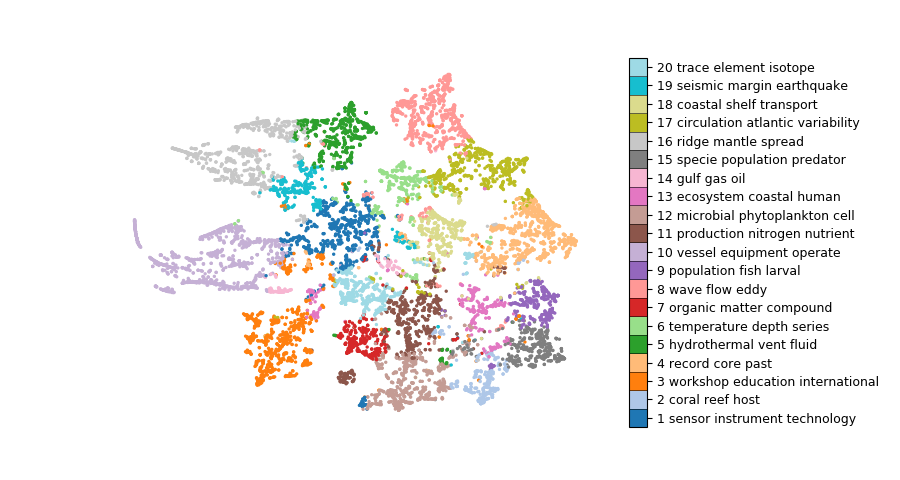

In [4]:
fig, ax = plt.subplots(figsize=(9,4.8))
fig.subplots_adjust(right=0.8)
sp = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=2, c=awards.topic.values, cmap=plt.cm.tab20, alpha=1)
ax.axis('off')
cb = fig.colorbar(sp,ax=ax,values=range(n_topics),boundaries=range(n_topics+1),ticks=np.arange(0.5,n_topics+0.5),
                  drawedges=True)
cb.set_ticklabels(topic_names_r)
cb.ax.tick_params(labelsize=9)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

### Distribution of awards by NSF-OCE program

#### Top 10 NSF-OCE programs in number of awards

In [5]:
top10_number = awards.groupby('program')['Abstract'].count().sort_values(ascending=False)[:10]
top10_number

program
MARINE GEOLOGY AND GEOPHYSICS     2514
BIOLOGICAL OCEANOGRAPHY           2064
PHYSICAL OCEANOGRAPHY             1795
CHEMICAL OCEANOGRAPHY             1336
OCEAN TECH & INTERDISC COORDIN     452
OCEANOGRAPHIC INSTRUMENTATION      450
SHIPBOARD SCIENTIFIC SUPP EQUI     369
OCEAN DRILLING PROGRAM             313
EDUCATION/HUMAN RESOURCES          229
MAJOR RESEARCH INSTRUMENTATION     162
Name: Abstract, dtype: int64

#### Distribution of awards

<IPython.core.display.Javascript object>


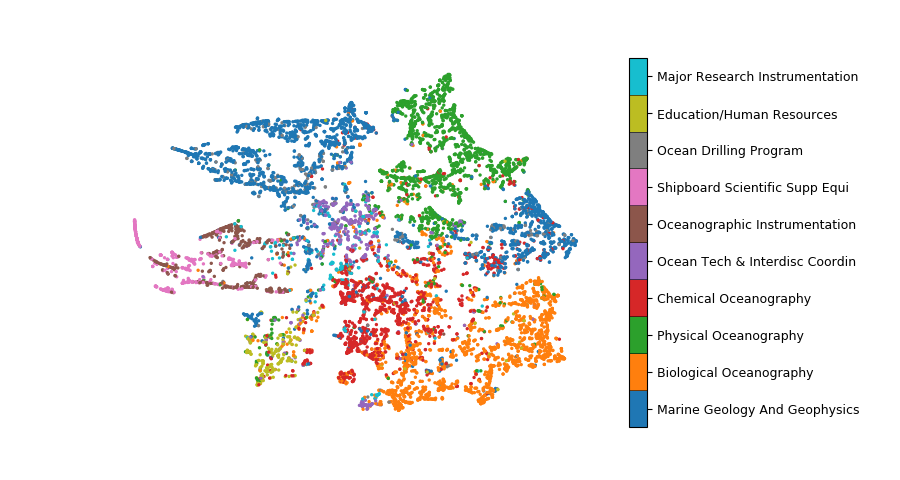

In [6]:
for n, p in enumerate(top10_number.index):
    awards.loc[awards.program==p,'top10'] = n

nprogs = len(top10_number)
top10  = awards.top10.notnull()

fig, ax = plt.subplots(figsize=(9,4.8))
fig.subplots_adjust(right=0.8)
sp = ax.scatter(X_tsne[top10,0], X_tsne[top10,1], s=2, c=awards.top10[top10].values, cmap=plt.cm.tab10)
ax.axis('off')
cb = fig.colorbar(sp,ax=ax,values=range(nprogs),boundaries=range(nprogs+1),ticks=np.arange(0.5,nprogs+0.5), 
                  drawedges=True)
cb.set_ticklabels([s.title() for s in top10_number.index])
cb.ax.tick_params(labelsize=9)

### Distribution of awards & interdisciplinarity

Higher values (closer to one) mean more interdisciplinary.

<IPython.core.display.Javascript object>


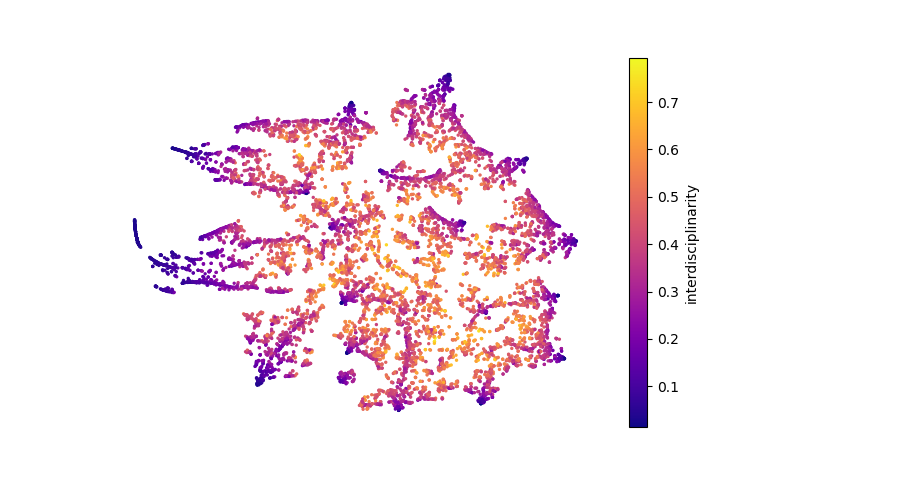

In [7]:
fig, ax = plt.subplots(figsize=(9,4.8))
fig.subplots_adjust(right=0.8)
sp = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=2, c=awards.evenness.values, cmap=plt.cm.plasma, alpha=1)
ax.axis('off')
cb = fig.colorbar(sp,ax=ax)
cb.set_label('interdisciplinarity')

## Trends in time

The years 1985, 1986 and 2018 contain only 2, 2 and 27 awards with valid abstracts, respectively. As a result, the annual statistics for these years are highly biased and not representative of all the awards in those years, and therefore were removed from the time series analysis presented below.

In [8]:
import statsmodels.api as sm
topic_numbers = awards.topic.unique()
topic_numbers.sort()
topic_names_s = [' '.join(s.split()[:3]) for s in topic_names]
probs = probs[awards.StartDate.dt.year > 1986]   # remove data before 1987 (4 awards)
probs = probs[awards.StartDate.dt.year < 2018]   # remove 2018 data (27 awards)
awards = awards[awards.StartDate.dt.year > 1986] # remove data before 1987 (4 awards)
awards = awards[awards.StartDate.dt.year < 2018] # remove 2018 data (27 awards)
year = [yr for yr in awards.StartDate.dt.year]   # year of each award
figsize = (9.5,8)

/opt/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


### Trends in interdisciplinarity

#### Annual mean award interdisciplinarity for each topic

<IPython.core.display.Javascript object>


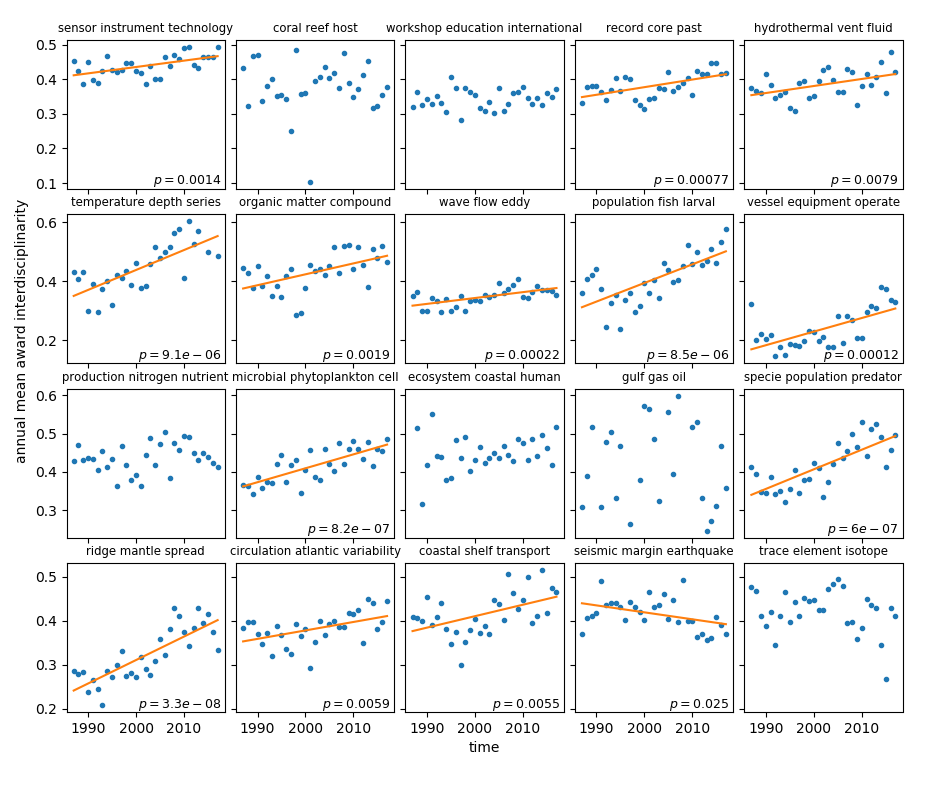

In [9]:
evenness = awards.groupby(by=[awards.StartDate.dt.year,awards.topic])['evenness'].mean().reset_index()
evenness = evenness.dropna()
fig, axs = plt.subplots(4, 5, sharex=True, sharey='row', figsize=figsize)
fig.subplots_adjust(left=0.07, right=0.95, top=0.95, hspace=0.175, wspace=0.07)
for t, ax in zip(topic_numbers, axs.ravel()):
    x, y = evenness.StartDate[evenness.topic==t].values, evenness.evenness[evenness.topic==t]
    _ = ax.plot(x, y, '.')
    _ = ax.set_title('{}'.format(topic_names_s[t]), fontsize=8.4)
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    p = lreg.pvalues[1]
    if p < 0.05:
        _ = ax.text(0.975,0.05, '$p={:.2g}$'.format(p),transform=ax.transAxes,ha='right',va='center',fontsize=9)
        _ = ax.plot(x, lreg.predict(X), 'C1-')
        
    _ = axs[2,0].set_ylabel('annual mean award interdisciplinarity',horizontalalignment='left')
    _ = axs[3,2].set_xlabel('time')

### Topic trends 

#### Annual frequency of awards for each topic

<IPython.core.display.Javascript object>


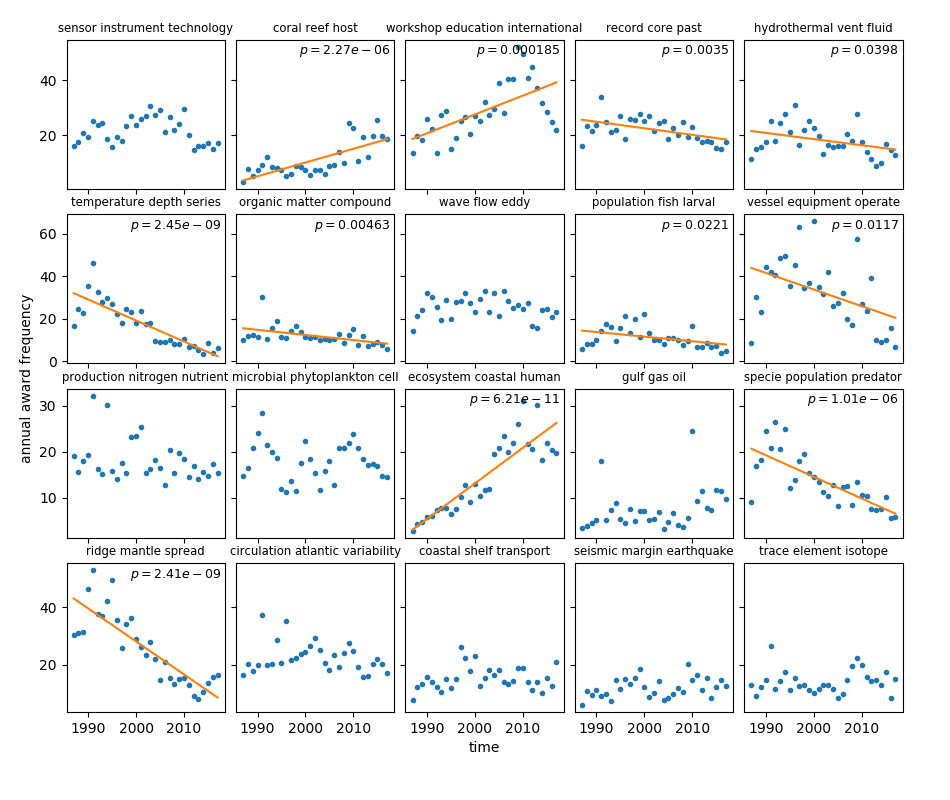

In [10]:
freq_topic_year = probs.groupby(year).sum()
frequency = freq_topic_year.stack()
frequency.index.rename('year',level=0,inplace=True)
frequency.index.rename('topic',level=1,inplace=True)
frequency = frequency.rename('freq').reset_index()

fig, axs = plt.subplots(4, 5, sharex=True, sharey='row', figsize=figsize)
fig.subplots_adjust(left=0.07, right=0.95, top=0.95, hspace=0.175, wspace=0.07)
for t, ax in zip(topic_numbers, axs.ravel()):
    x, y = frequency.year[frequency.topic==t].values, frequency.freq[frequency.topic==t]
    _ = ax.plot(x, y, '.')
    _ = ax.set_title('{}'.format(topic_names_s[t]), fontsize=8.4)
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    p = lreg.pvalues[1]
    if p < 0.05:
        _ = ax.text(0.975,0.925, '$p={:.3g}$'.format(p),transform=ax.transAxes,ha='right',va='center',fontsize=9)
        _ = ax.plot(x, lreg.predict(X), 'C1-')
        
    _ = axs[2,0].set_ylabel('annual award frequency',horizontalalignment='left')
    _ = axs[3,2].set_xlabel('time')

#### Annual fraction of the number of awards for each topic

<IPython.core.display.Javascript object>


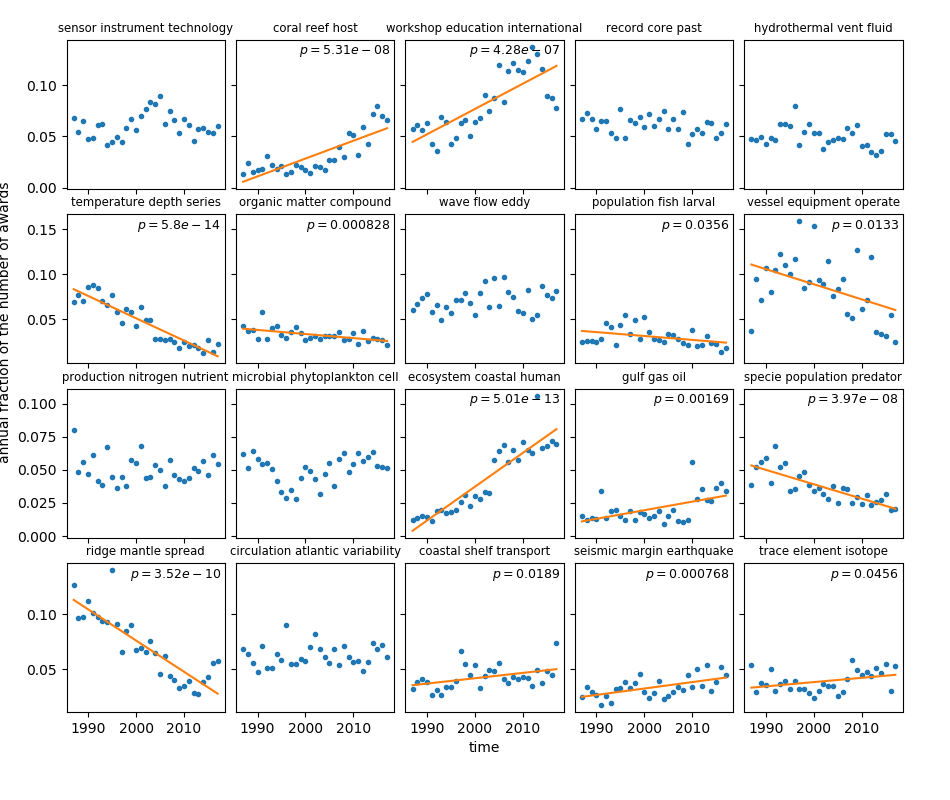

In [11]:
frac_topic_year = probs.groupby(year).mean()
fraction = frac_topic_year.stack()
fraction.index.rename('year',level=0,inplace=True)
fraction.index.rename('topic',level=1,inplace=True)
fraction = fraction.rename('frac').reset_index()

fig, axs = plt.subplots(4, 5, sharex=True, sharey='row', figsize=figsize)
fig.subplots_adjust(left=0.07, right=0.95, top=0.95, hspace=0.175, wspace=0.07)
for t, ax in zip(topic_numbers, axs.ravel()):
    x, y = fraction.year[fraction.topic==t].values, fraction.frac[fraction.topic==t]
    _ = ax.plot(x, y, '.')
    _ = ax.set_title('{}'.format(topic_names_s[t]), fontsize=8.4)
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    p = lreg.pvalues[1]
    if p < 0.05:
        _ = ax.text(0.975,0.925, '$p={:.3g}$'.format(p),transform=ax.transAxes,ha='right',va='center',fontsize=9)
        _ = ax.plot(x, lreg.predict(X), 'C1-')
        
_ = axs[2,0].set_ylabel('annual fraction of the number of awards',horizontalalignment='left')
_ = axs[3,2].set_xlabel('time')

### Funding trends 

#### Annual amount awarded for each topic

<IPython.core.display.Javascript object>


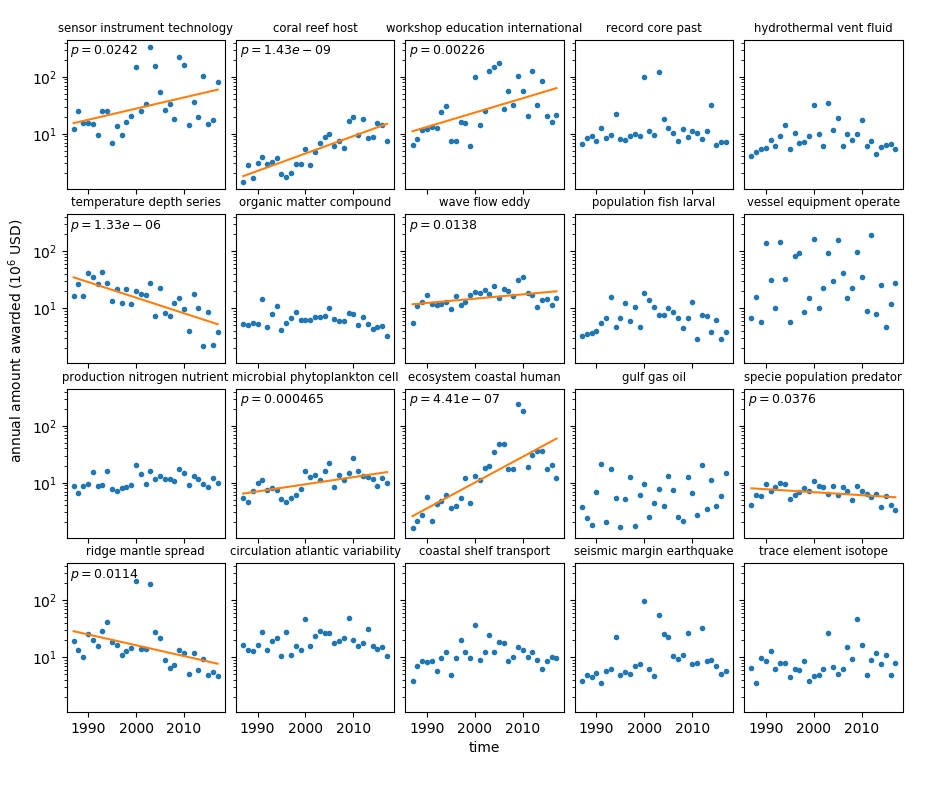

In [12]:
amount = probs.mul(awards.amount_adjusted * 1.e-6, axis='index') # in millions of USD
amount['year'] = year
amount_topic_year = amount.groupby('year').sum()
amount = amount_topic_year.stack()
amount.index.rename('topic',level=1,inplace=True)
amount = amount.rename('dollars').reset_index()

fig, axs = plt.subplots(4, 5, sharex=True, sharey=True, figsize=figsize)
fig.subplots_adjust(left=0.07, right=0.95, top=0.95, hspace=0.175, wspace=0.07)
for t, ax in zip(topic_numbers, axs.ravel()):    
    x, y = amount.year[amount.topic==t].values, amount.dollars[amount.topic==t]
    _ = ax.plot(x, y, '.')
    _ = ax.set_title('{}'.format(topic_names_s[t]), fontsize=8.4)
    _ = ax.set_yscale('log')
    X = sm.add_constant(x)
    lreg = sm.OLS(np.log(y),X).fit()
    p = lreg.pvalues[1]
    if p <= 0.05:
        _ = ax.text(0.025,0.925, '$p={:.3g}$'.format(p),transform=ax.transAxes,ha='left',va='center',fontsize=9)
        _ = ax.plot(x, np.exp(lreg.predict(X)), 'C1-')
                
_ = axs[2,0].set_ylabel('annual amount awarded ($10^6$ USD)',horizontalalignment='left')
_ = axs[3,2].set_xlabel('time')

#### Topic share/fraction of annual amount awarded

<IPython.core.display.Javascript object>


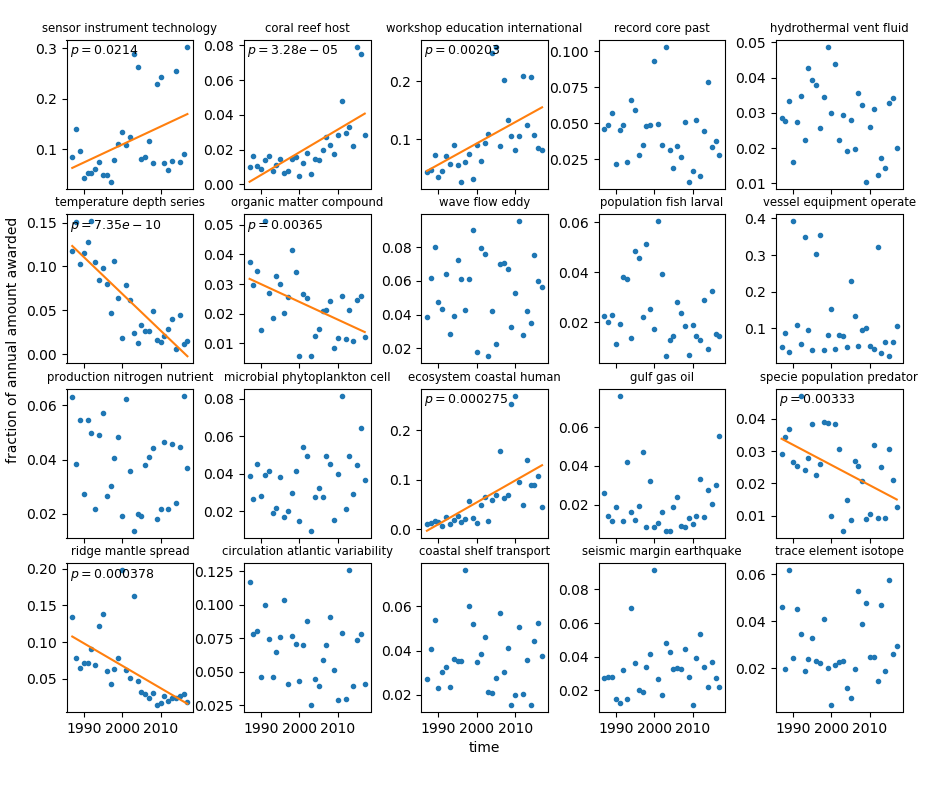

In [13]:
share_topic_year = amount_topic_year.div(amount_topic_year.sum(axis=1), axis='index')
share = share_topic_year.stack()
share.index.rename('topic',level=1,inplace=True)
share = share.rename('share').reset_index()

fig, axs = plt.subplots(4, 5, sharex=True, sharey=False, figsize=figsize)
fig.subplots_adjust(left=0.07, right=0.95, top=0.95, hspace=0.175, wspace=0.4)
for t, ax in zip(topic_numbers, axs.ravel()):
    x, y = share.year[share.topic==t].values, share.share[amount.topic==t]
    _ = ax.plot(x, y, '.')
    _ = ax.set_title('{}'.format(topic_names_s[t]), fontsize=8.4)
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    p = lreg.pvalues[1]
    if p <= 0.05:
        _ = ax.text(0.025,0.925, '$p={:.3g}$'.format(p),transform=ax.transAxes,ha='left',va='center',fontsize=9)
        _ = ax.plot(x, lreg.predict(X), 'C1-')
        
_ = axs[2,0].set_ylabel('fraction of annual amount awarded',horizontalalignment='left')
_ = axs[3,2].set_xlabel('time')

### Metatopic trends

In [14]:
education = [2]
infrastructure = [0, 9, 13]
science = [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19]

# annual frequency of awards for each metatopic
freq_year_metatopics = pd.DataFrame(freq_topic_year[science].sum(axis=1),columns=['science'])
freq_year_metatopics['education'] = freq_topic_year[education]
freq_year_metatopics['infrastructure'] = freq_topic_year[infrastructure].sum(axis=1)

# annual fraction of the number of awards for each metatopic
frac_year_metatopics = pd.DataFrame(frac_topic_year[science].sum(axis=1),columns=['science'])
frac_year_metatopics['education'] = frac_topic_year[education]
frac_year_metatopics['infrastructure'] = frac_topic_year[infrastructure].sum(axis=1)

# annual amount awarded for each metatopic
amount_year_metatopics = pd.DataFrame(amount_topic_year[science].sum(axis=1),columns=['science'])
amount_year_metatopics['education'] = amount_topic_year[education]
amount_year_metatopics['infrastructure'] = amount_topic_year[infrastructure].sum(axis=1)

# metatopic share/fraction of annual amount awarded
share_year_metatopics = pd.DataFrame(share_topic_year[science].sum(axis=1),columns=['science'])
share_year_metatopics['education'] = share_topic_year[education]
share_year_metatopics['infrastructure'] = share_topic_year[infrastructure].sum(axis=1)

# mean amount awarded per project per year for each metatopic
amount_per_award = amount_year_metatopics/freq_year_metatopics

The metatopic data shows large variations from year to year so the annual values were smoothed using a 3-year sliding window average to help visualize trends.

<IPython.core.display.Javascript object>


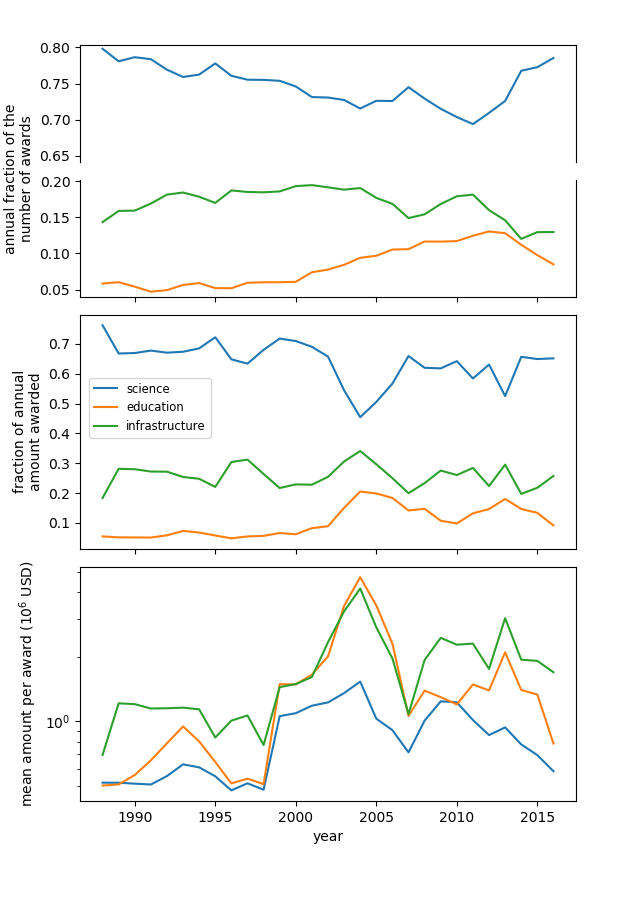

In [15]:
nn = 3 # size of sliding window in years
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(6.4,9), gridspec_kw={'height_ratios':[1,1,2,2]})
fig.subplots_adjust(top=0.95,hspace=0.1)
_ = frac_year_metatopics[['science']].rolling(nn,center=True).mean().plot(ax=axs[0],subplots=False,style='-',
                                                                          sharex=True,legend=False)
_ = frac_year_metatopics[['education','infrastructure']].rolling(nn,center=True).mean().plot(ax=axs[1],subplots=False,
                                                                                            style=['C1-','C2-'],
                                                                                            sharex=True,legend=False)
axs[0].set_ylabel('annual fraction of the\nnumber of awards', ha='right', multialignment='center')
axs[0].spines['bottom'].set_color('none')
axs[0].xaxis.set_ticks_position('none')
axs[1].spines['top'].set_color('none')
# rescale y axis to be the same size
y1, y2 = axs[0].get_ylim()
y3, y4 = axs[1].get_ylim() 
_ = axs[0].set_ylim(y2-(y4-y3), y2)

_ = share_year_metatopics.rolling(nn,center=True).mean().plot(ax=axs[2],subplots=False,style='-',
                                                             sharex=True).legend(bbox_to_anchor=(0.275, 0.45))
_ = axs[2].set_ylabel('fraction of annual\namount awarded', ha='center', multialignment='center')

_ = amount_per_award.rolling(nn,center=True).mean().plot(ax=axs[3],subplots=False,style='-',sharex=True,
                                                        legend=False,logy=True)
_ = axs[3].set_ylabel('mean amount per award ($10^6$ USD)')

### Amount awarded to individual projects and total annual amount awarded

<IPython.core.display.Javascript object>


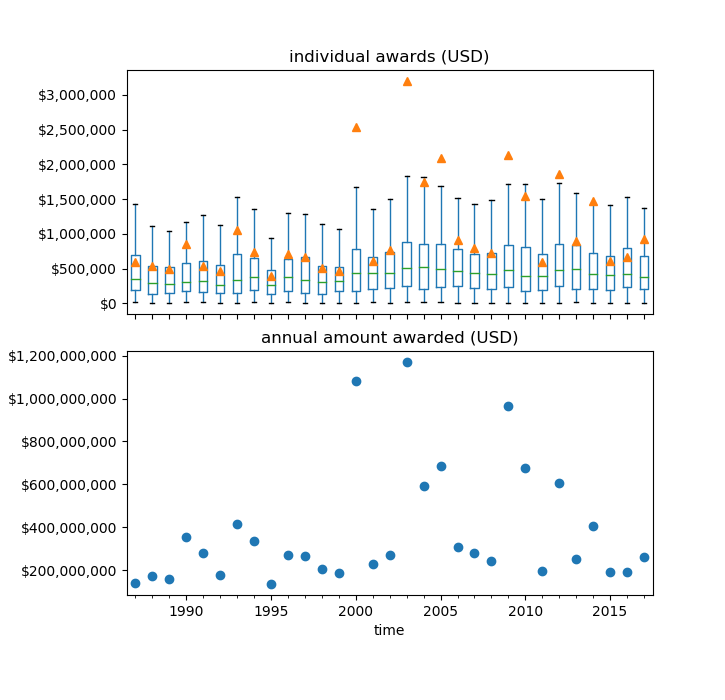

In [16]:
# total annual amount awarded
annual_amount = awards.groupby(awards.StartDate.dt.year)['amount_adjusted'].sum()
annual_amount.index = pd.to_datetime(annual_amount.index.values,format='%Y')

# amount awarded to individual projects
projects = awards[['StartDate', 'amount_adjusted']]
projects = projects.set_index('StartDate')
projects = projects.sort_index()
projects['year'] = projects.index.year

def dollar(x, pos):
    return '${:,.0f}'.format(x)
fmt = ticker.FuncFormatter(dollar)

meanprops = dict(markeredgecolor='C1', markerfacecolor='C1')

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(7.25,7))
_ = projects.boxplot('amount_adjusted',by='year',ax=axs[0], grid=False, rot=90, bootstrap=1000, showfliers=False, 
                     showmeans=True, meanprops=meanprops)
_ = axs[0].set(xticklabels=[], xlabel='', title='individual awards (USD)')
axs[0].yaxis.set_major_formatter(fmt)
_ = annual_amount.plot(ax=axs[1], style='o')
_ = axs[1].set(xlabel='time', title='annual amount awarded (USD)', xlim=(16.5,47.5))
axs[1].yaxis.set_major_formatter(fmt)

fig.suptitle('')
fig.subplots_adjust(left=0.175, hspace=0.15)